In [3]:
from scipy import ndimage
def vecToCSVLine(vector):
    line = ""
    for i, val in enumerate(vector):
        line += str(val)
        if i < len(vector) - 1:
            line += ", "
    line += "\n"
    return line

def CSVLineToVec(line):
    line_list = line.strip().replace("\n", "").split(",")
    float_list = []
    for i in line_list:
        float_list.append(float(i))
    float_list = np.array(float_list)
    return float_list

# Revised for Toy Example
def oracleTriplet(p1, p2, p3):
    b_1, i1 = p1
    b_2, i2 = p2
    b_3, i3 = p3
    if b_1 == b_2 and b_2 == b_3:
        return None
    elif b_1 == b_2:
        trip = [i1, i2, i3]
    elif b_2 == b_3:
        trip = [i2, i3, i1]
    elif b_3 == b_1:
        trip = [i3, i1, i2]
    else:
        return None
    return trip

def train(ensemble, anchor_img, pos_img, neg_img, transform=True):
    if transform:
        pos_images = np.stack([
            [ndimage.rotate(pos_img, 90)],
            [ndimage.rotate(pos_img, 180)],
            [ndimage.rotate(pos_img, 270)],
        ])
    else:
        pos_images = np.array([[pos_img]])
    anchor_images = np.stack([[anchor_img] for _ in pos_images])
    neg_images = np.stack([[neg_img] for _ in pos_images])
    losses = ensemble.train_batch(anchor_images, pos_images, neg_images)
    return np.array(losses)

def train_batch(ensemble, anchor_batch, pos_batch, neg_batch, transform=True):
    losses = ensemble.train_batch(anchor_batch, pos_batch, neg_batch)
    return np.array(losses)

In [2]:
import torch
import os
import numpy as np
from data.swarmset import ContinuingDataset, SwarmDataset
sampled_dataset = SwarmDataset("data/tinytoy", rank=0)

DATA_TEST_SIZE = 3000
OUT = "data/toy-oracle"

with open(os.path.join(OUT, "triplets.txt"), "w") as f:
    for i in range(DATA_TEST_SIZE):
        b = np.random.randint(len(sampled_dataset), size=3)
        a, p, n = b[0], b[1], b[2]
        b1, b2, b3 = sampled_dataset[b[0]][2][0], sampled_dataset[b[1]][2][0], sampled_dataset[b[2]][2][0]
        triplet = oracleTriplet((b1, a), (b2, p), (b3, n))
        if not triplet:
            continue
        f.write(vecToCSVLine(triplet))

pygame 2.1.2 (SDL 2.0.16, Python 3.10.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [66]:
import random
import torch
import os
import numpy as np
from src.networks.ensemble import Ensemble
from data.swarmset import ContinuingDataset, SwarmDataset
PRETRAINING = True
target = 0.01
loss = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ensembleA = Ensemble(size=3, output_size=5, lr=3e-4, learning_decay=0.95, decay_step=3, new_model=True)
ensembleA.load_ensemble("tiny-toy-C")
sampled_dataset = SwarmDataset("data/tinytoy", rank=0)
data = sampled_dataset

total_queries = 0
validation_accuracy = []
per_network_acc = [[] for _ in ensembleA.ensemble]
overall_training_average = []

# Get initial Accuracy
# Validation on Oracle Dataset
validation_accuracy = []
OUT = "data/toy-oracle"
with open(os.path.join(OUT, "triplets.txt"), "r") as f:
    lines = f.readlines()
    total_score = 0
    network_score = np.array([0.0 for _ in ensembleA.ensemble])
    for line in lines:
        triplet = CSVLineToVec(line)
        majority, l = ensembleA.majority_belief(sampled_dataset[int(triplet[0])][0], sampled_dataset[int(triplet[1])][0], sampled_dataset[int(triplet[2])][0])
        bin_loss = []
        for i, loss in enumerate(l):
            bin_loss.append(l[i] < ensembleA.margin)
        network_score += np.array(bin_loss)
        total_score += majority
    acc = total_score / len(lines)
    net_acc = network_score / len(lines)

    for i, net in enumerate(net_acc):
        per_network_acc[i].append(net)
        print(f"Network {i + 1}, Accuracy: {net * 100}%")

    validation_accuracy.append(acc)
    print(f"Pre-Query Validation Complete. Accuracy: {acc * 100}%")

TRIAL_SIZE = 10
training_triplets = []
pretraining_triplets = []
for global_epochs in range(TRIAL_SIZE):
    # Get Least Agreed Upon Triplets, then query the oracle
    SAMPLES = 4000
    rand_samp = [
        (random.randrange(0, len(data)), random.randrange(0, len(data)), random.randrange(0, len(data))) for i in range(SAMPLES)
    ]

    entropy = []
    for i in range(SAMPLES):
        ensembleA.eval_mode()
        h = ensembleA.variance(data[rand_samp[i][0]][0], positive=data[rand_samp[i][1]][0], negative=data[rand_samp[i][2]][0])
        entropy.append((h, i))
    entropy.sort(reverse=True)

    # Query the N most-disagreed upon Triplets
    N = min(SAMPLES, 500)
    for i in range(N):
        # Generate UserTriplets
        samp_index = entropy[i][1]
        a, p, n = rand_samp[samp_index]
        b1, b2, b3 = data[a][2][0], data[p][2][0], data[n][2][0]
        triplet = oracleTriplet((b1, a), (b2, p), (b3, n))
        if not triplet or triplet in training_triplets:
            continue
        training_triplets.append(triplet)

        # Generate Pretraining Triplets
        # a, n = rand_samp[i][0], rand_samp[i][2]
        # pretraining_triplets.append([a, n])

    total_queries += N

    # Train on the training triplets for 5 epochs
    EPOCHS = 500
    CONTINUE_PRE = 0
    pretraining_counter = 0
    pretraining_max = 1000

    assert pretraining_max < SAMPLES

    training_losses = []
    for epoch in range(EPOCHS):
        ensembleA.training_mode()
        total_loss = [0.0 for _ in ensembleA.ensemble]
        pretraining_loss = [0.0 for _ in ensembleA.ensemble]
        updates = 0
        pre_updates = 0
        BATCH_SIZE = 4

        if BATCH_SIZE < CONTINUE_PRE:
            raise Exception("Invalid Config: Batch Size must be larger than the continue pretraining metric.")

        random.shuffle(training_triplets)
        for i in range(0, len(training_triplets), BATCH_SIZE - CONTINUE_PRE):
            anchors = []
            positives = []
            negatives = []
            if (i + BATCH_SIZE - CONTINUE_PRE) > len(training_triplets):
                break

            for j in range(BATCH_SIZE - CONTINUE_PRE):
                triplet = training_triplets[i + j]
                anchors.append(data[triplet[0]][0])
                positives.append(data[triplet[1]][0])
                negatives.append(data[triplet[2]][0])

            for l in range(CONTINUE_PRE):
                triplet = rand_samp[pretraining_counter % pretraining_max]
                anchors.append(data[triplet[0]][0])
                positives.append(ndimage.rotate(data[triplet[0]][0], 90))
                negatives.append(data[triplet[2]][0])
                pretraining_counter += 1

            assert len(anchors) == BATCH_SIZE, "Batch Size is inconsistent in code!"

            anchors = np.expand_dims(anchors, axis=1)
            positives = np.expand_dims(positives, axis=1)
            negatives = np.expand_dims(negatives, axis=1)
            total_loss += train_batch(ensembleA, np.array(anchors), np.array(positives), np.array(negatives))
            updates += 1

        lrs = ensembleA.evaluate_lr(total_loss / updates)
        print(f"LR: {lrs}")

        average_loss = sum(total_loss) / (len(ensembleA.ensemble) * updates)
        training_losses.append(average_loss)

        WINDOW_SIZE = 7
        window_average = sum(training_losses[-WINDOW_SIZE:]) / WINDOW_SIZE
        if len(training_losses) > WINDOW_SIZE and window_average < 0.01:
            break
        print(f"Epoch {epoch} Complete. Network Loss: {total_loss / updates}. Ensemble Loss: {average_loss}")
        print(f"Window Average Loss: {window_average}")

    overall_training_average.append(sum(training_losses) / len(training_losses))

    # Validation on Oracle Dataset
    ensembleA.eval_mode()
    OUT = "data/toy-oracle"
    with open(os.path.join(OUT, "triplets.txt"), "r") as f:
        lines = f.readlines()
        total_score = 0
        network_score = np.array([0.0 for _ in ensembleA.ensemble])
        for line in lines:
            triplet = CSVLineToVec(line)
            majority, l = ensembleA.majority_belief(sampled_dataset[int(triplet[0])][0], sampled_dataset[int(triplet[1])][0], sampled_dataset[int(triplet[2])][0])
            bin_loss = []
            for i, loss in enumerate(l):
                bin_loss.append(l[i] < ensembleA.margin)
            network_score += np.array(bin_loss)
            total_score += majority
        acc = total_score / len(lines)
        net_acc = network_score / len(lines)

        for i, net in enumerate(net_acc):
            per_network_acc[i].append(net)
            print(f"Network {i + 1}, Accuracy: {net * 100}%")

        validation_accuracy.append(acc)
        print(f"Validation Complete. Accuracy: {acc * 100}%")

    ensembleA.set_lr(5e-4, 0.95)

FileNotFoundError: [Errno 2] No such file or directory: 'checkpoints/ensembles/tiny-toy-D/0.pt'

In [14]:
triplet_set = set()
for trip in training_triplets:
    triplet_set.add((trip[0], trip[1], trip[2]))
len(triplet_set)

1954

In [5]:
import time
ensembleA.save_ensemble(f"{int(time.time())}")

[0.563819095477387, 0.6266331658291457, 0.7160804020100503, 0.7814070351758794, 0.8542713567839196, 0.892462311557789, 0.9487437185929648]


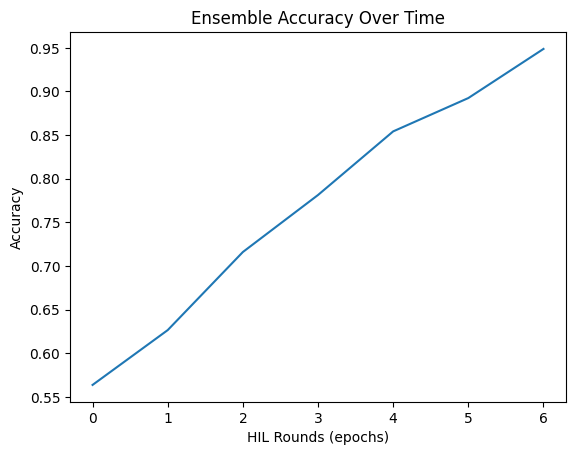

[3.6068499218082377, 0.8467626101188384, 0.517717022322869, 0.3109987031927689, 0.18863121139309508, 0.12786978196932888]


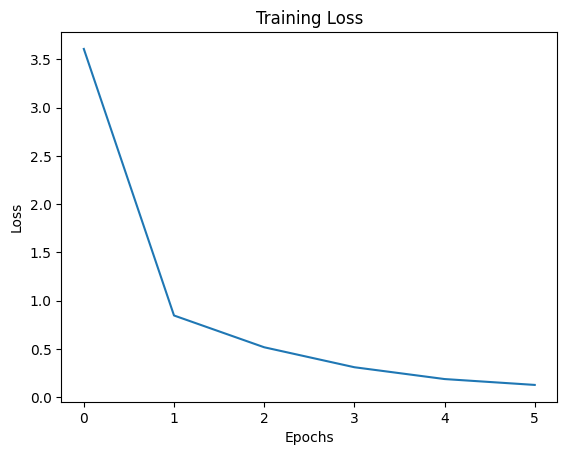

[[0.5266331658291458, 0.5678391959798995, 0.6150753768844222, 0.6728643216080402, 0.7462311557788944, 0.821105527638191, 0.9020100502512562], [0.6055276381909548, 0.664321608040201, 0.7698492462311558, 0.8150753768844221, 0.8633165829145729, 0.8763819095477386, 0.9080402010050251], [0.5633165829145729, 0.6025125628140704, 0.6552763819095477, 0.6969849246231156, 0.7603015075376884, 0.799497487437186, 0.8748743718592965]]


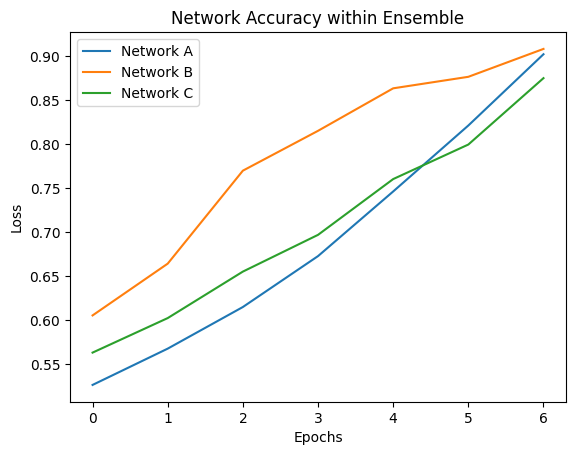

In [6]:
import matplotlib.pyplot as plot
print(validation_accuracy)
plot.plot(validation_accuracy)
plot.title("Ensemble Accuracy Over Time")
plot.ylabel("Accuracy")
plot.xlabel("HIL Rounds (epochs)")
plot.show()

print(overall_training_average)
plot.plot(overall_training_average)
plot.title("Training Loss")
plot.ylabel("Loss")
plot.xlabel("Epochs")
plot.show()

print(per_network_acc)
plot.plot(per_network_acc[0], label="Network A")
plot.plot(per_network_acc[1], label="Network B")
plot.plot(per_network_acc[2], label="Network C")
plot.title("Network Accuracy within Ensemble")
plot.ylabel("Loss")
plot.xlabel("Epochs")
plot.legend()

In [47]:
import random
import torch
import os
import numpy as np
from src.networks.ensemble import Ensemble
from data.swarmset import ContinuingDataset, SwarmDataset
PRETRAINING = True
target = 0.01
loss = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ensembleA = Ensemble(size=3, output_size=5, lr=3e-4, learning_decay=0.95, decay_step=3, new_model=True)
ensembleA.load_ensemble("tiny-toy-C")
sampled_dataset = SwarmDataset("data/tinytoy", rank=0)
data = sampled_dataset

total_queries = 0
validation_accuracy = [0.6039603960396039]
per_network_acc = [[] for _ in ensembleA.ensemble]
overall_training_average = []


# Get initial Accuracy
# Validation on Oracle Dataset
validation_accuracy = []
OUT = "data/toy-oracle"
with open(os.path.join(OUT, "triplets.txt"), "r") as f:
    lines = f.readlines()
    total_score = 0
    network_score = np.array([0.0 for _ in ensembleA.ensemble])
    for line in lines:
        triplet = CSVLineToVec(line)
        majority, l = ensembleA.majority_belief(sampled_dataset[int(triplet[0])][0], sampled_dataset[int(triplet[1])][0], sampled_dataset[int(triplet[2])][0])
        bin_loss = []
        for i, loss in enumerate(l):
            bin_loss.append(l[i] < ensembleA.margin)
        network_score += np.array(bin_loss)
        total_score += majority
    acc = total_score / len(lines)
    net_acc = network_score / len(lines)

    for i, net in enumerate(net_acc):
        per_network_acc[i].append(net)
        print(f"Network {i + 1}, Accuracy: {net * 100}%")

    validation_accuracy.append(acc)
    print(f"Pre-Query Validation Complete. Accuracy: {acc * 100}%")

TRIAL_SIZE = 10
training_triplets = []
pretraining_triplets = []
for global_epochs in range(TRIAL_SIZE):
    # Get Least Agreed Upon Triplets, then query the oracle
    SAMPLES = 4000
    rand_samp = [
        (random.randrange(0, len(data)), random.randrange(0, len(data)), random.randrange(0, len(data))) for i in range(SAMPLES)
    ]

    # Query the N most-disagreed upon Triplets
    N = min(SAMPLES, 500)
    for i in range(N):
        # Generate UserTriplets
        a, p, n = rand_samp[i]
        b1, b2, b3 = data[a][2], data[p][2], data[n][2]
        triplet = oracleTriplet((b1, a), (b2, p), (b3, n))
        if triplet is None:
            continue
        training_triplets.append(triplet)

        # Generate Pretraining Triplets
        a, n = rand_samp[i][0], rand_samp[i][2]
        pretraining_triplets.append([a, n])

    total_queries += N

    # Train on the training triplets for 5 epochs
    EPOCHS = 500
    CONTINUE_PRE = 0
    pretraining_counter = 0
    pretraining_max = 1200

    assert pretraining_max < SAMPLES

    training_losses = []
    for epoch in range(EPOCHS):
        ensembleA.training_mode()
        total_loss = [0.0 for _ in ensembleA.ensemble]
        pretraining_loss = [0.0 for _ in ensembleA.ensemble]
        updates = 0
        pre_updates = 0
        BATCH_SIZE = 4

        if BATCH_SIZE < CONTINUE_PRE:
            raise Exception("Invalid Config: Batch Size must be larger than the continue pretraining metric.")

        random.shuffle(training_triplets)
        for i in range(0, len(training_triplets), BATCH_SIZE - CONTINUE_PRE):
            anchors = []
            positives = []
            negatives = []
            if (i + BATCH_SIZE - CONTINUE_PRE) > len(training_triplets):
                break

            for j in range(BATCH_SIZE - CONTINUE_PRE):
                triplet = training_triplets[i + j]
                anchors.append(data[triplet[0]][0])
                positives.append(data[triplet[1]][0])
                negatives.append(data[triplet[2]][0])

            for l in range(CONTINUE_PRE):
                triplet = rand_samp[pretraining_counter % pretraining_max]
                anchors.append(data[triplet[0]][0])
                positives.append(ndimage.rotate(data[triplet[0]][0], 90))
                negatives.append(data[triplet[2]][0])
                pretraining_counter += 1

            assert len(anchors) == BATCH_SIZE, "Batch Size is inconsistent in code!"

            anchors = np.expand_dims(anchors, axis=1)
            positives = np.expand_dims(positives, axis=1)
            negatives = np.expand_dims(negatives, axis=1)
            total_loss += train_batch(ensembleA, np.array(anchors), np.array(positives), np.array(negatives))
            updates += 1

        lrs = ensembleA.evaluate_lr(total_loss / updates)
        print(f"LR: {lrs}")

        average_loss = sum(total_loss) / (len(ensembleA.ensemble) * updates)
        training_losses.append(average_loss)

        WINDOW_SIZE = 7
        window_average = sum(training_losses[-WINDOW_SIZE:]) / WINDOW_SIZE
        if len(training_losses) > WINDOW_SIZE and window_average < 0.01:
            break
        print(f"Epoch {epoch} Complete. Network Loss: {total_loss / updates}. Ensemble Loss: {average_loss}")
        print(f"Window Average Loss: {window_average}")

    overall_training_average.append(sum(training_losses) / len(training_losses))

    # Validation on Oracle Dataset
    ensembleA.eval_mode()
    OUT = "data/toy-oracle"
    with open(os.path.join(OUT, "triplets.txt"), "r") as f:
        lines = f.readlines()
        total_score = 0
        network_score = np.array([0.0 for _ in ensembleA.ensemble])
        for line in lines:
            triplet = CSVLineToVec(line)
            majority, l = ensembleA.majority_belief(sampled_dataset[int(triplet[0])][0], sampled_dataset[int(triplet[1])][0], sampled_dataset[int(triplet[2])][0])
            bin_loss = []
            for i, loss in enumerate(l):
                bin_loss.append(l[i] < ensembleA.margin)
            network_score += np.array(bin_loss)
            total_score += majority
        acc = total_score / len(lines)
        net_acc = network_score / len(lines)

        for i, net in enumerate(net_acc):
            per_network_acc[i].append(net)
            print(f"Network {i + 1}, Accuracy: {net * 100}%")

        validation_accuracy.append(acc)
        print(f"Validation Complete. Accuracy: {acc * 100}%")

    ensembleA.set_lr(5e-4, 0.95)

Network 1, Accuracy: 52.663316582914575%
Network 2, Accuracy: 60.55276381909548%
Network 3, Accuracy: 56.33165829145729%
Pre-Query Validation Complete. Accuracy: 56.381909547738694%
LR: [[0.0003], [0.0003], [0.0003]]
Epoch 0 Complete. Network Loss: [24.49716506 15.92785199 30.64180332]. Ensemble Loss: 23.688940123813907
Window Average Loss: 3.3841343034019866
LR: [[0.0003], [0.0003], [0.0003]]
Epoch 1 Complete. Network Loss: [20.76396256 15.11263179 25.68540931]. Ensemble Loss: 20.520667886346335
Window Average Loss: 6.315658287165748
LR: [[0.0003], [0.0003], [0.0003]]
Epoch 2 Complete. Network Loss: [17.74573825 14.14153942 21.63928988]. Ensemble Loss: 17.842189182110918
Window Average Loss: 8.864542456038736
LR: [[0.0003], [0.0003], [0.0003]]
Epoch 3 Complete. Network Loss: [15.29093747 13.44722454 18.5399783 ]. Ensemble Loss: 15.759380102157593
Window Average Loss: 11.115882470632679
LR: [[0.0003], [0.0003], [0.0003]]
Epoch 4 Complete. Network Loss: [13.63021118 12.6415137  16.02812

[0.563819095477387, 0.6412060301507537, 0.7211055276381909, 0.8030150753768844, 0.8613065326633166, 0.8954773869346734, 0.8994974874371859, 0.9391959798994974, 0.963819095477387, 0.9753768844221106, 0.9889447236180905]


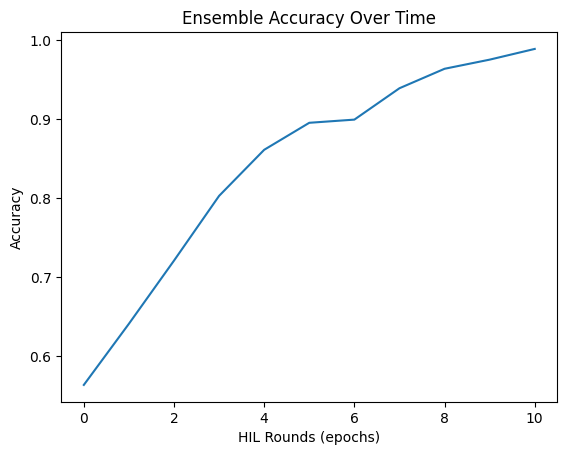

[2.503147135776718, 0.9698352741757554, 0.42903474416474063, 0.29786121688780676, 0.18197694240599618, 0.12620619925600218, 0.153260676837991, 0.07496492863084955, 0.05933731982733429, 0.06292551541069978]


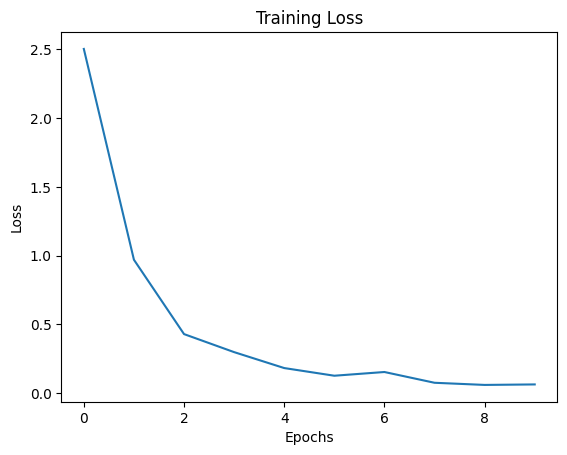

[[0.5266331658291458, 0.5381909547738694, 0.5989949748743718, 0.6517587939698493, 0.7261306532663316, 0.8, 0.8140703517587939, 0.892964824120603, 0.9422110552763819, 0.9633165829145729, 0.9824120603015075], [0.6055276381909548, 0.6688442211055277, 0.7618090452261307, 0.8477386934673367, 0.8979899497487437, 0.9160804020100503, 0.9296482412060302, 0.9432160804020101, 0.963819095477387, 0.963819095477387, 0.9748743718592965], [0.5633165829145729, 0.6211055276381909, 0.6758793969849246, 0.7351758793969849, 0.7638190954773869, 0.7723618090452261, 0.7979899497487437, 0.8236180904522613, 0.8306532663316583, 0.8557788944723618, 0.8773869346733668]]


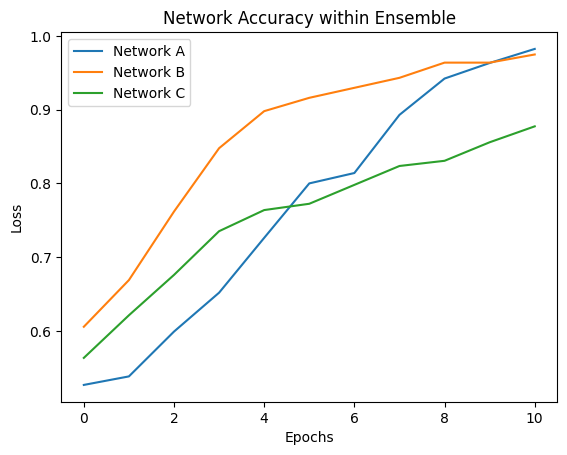

In [48]:
import matplotlib.pyplot as plot
print(validation_accuracy)
plot.plot(validation_accuracy)
plot.title("Ensemble Accuracy Over Time")
plot.ylabel("Accuracy")
plot.xlabel("HIL Rounds (epochs)")
plot.show()

print(overall_training_average)
plot.plot(overall_training_average)
plot.title("Training Loss")
plot.ylabel("Loss")
plot.xlabel("Epochs")
plot.show()

print(per_network_acc)
plot.plot(per_network_acc[0], label="Network A")
plot.plot(per_network_acc[1], label="Network B")
plot.plot(per_network_acc[2], label="Network C")
plot.title("Network Accuracy within Ensemble")
plot.ylabel("Loss")
plot.xlabel("Epochs")
plot.legend()

In [7]:
# Obtain info on No Training Model

import random
import torch
import os
import numpy as np
from src.networks.ensemble import Ensemble
from data.swarmset import ContinuingDataset, SwarmDataset
PRETRAINING = True
target = 0.01
loss = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ensemble_random = Ensemble(size=3, output_size=5, lr=6e-4, learning_decay=0.95, decay_step=3, margin=100, init="Random", new_model=True)
ensemble_random.load_ensemble("tiny-toy-CLR-3")
sampled_dataset = SwarmDataset("data/tinytoy", rank=0)
data = sampled_dataset

total_queries = 0
validation_accuracy = []
per_network_acc = [[] for _ in ensemble_random.ensemble]
overall_training_average = []

# Get initial Accuracy
# Validation on Oracle Dataset
OUT = "data/toy-oracle"
with open(os.path.join(OUT, "triplets.txt"), "r") as f:
    lines = f.readlines()
    total_score = 0
    network_score = np.array([0.0 for _ in ensemble_random.ensemble])
    for line in lines:
        triplet = CSVLineToVec(line)
        majority, l = ensemble_random.majority_belief(sampled_dataset[int(triplet[0])][0], sampled_dataset[int(triplet[1])][0], sampled_dataset[int(triplet[2])][0])
        bin_loss = []
        for i, loss in enumerate(l):
            bin_loss.append(l[i] < ensemble_random.margin)
        network_score += np.array(bin_loss)
        total_score += majority
    acc = total_score / len(lines)
    net_acc = network_score / len(lines)

    for i, net in enumerate(net_acc):
        per_network_acc[i].append(net)
        print(f"Network {i + 1}, Accuracy: {net * 100}%")

    validation_accuracy.append(acc)
    print(f"Pre-Query Validation Complete. Accuracy: {acc * 100}%")

Network 1, Accuracy: 51.65829145728643%
Network 2, Accuracy: 53.869346733668344%
Network 3, Accuracy: 49.497487437185924%
Pre-Query Validation Complete. Accuracy: 52.56281407035176%


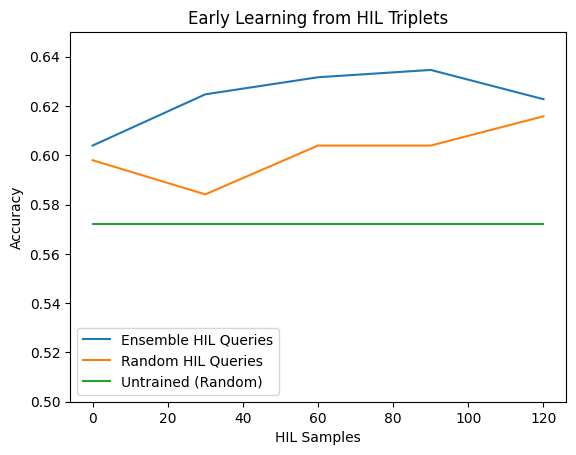

In [26]:
import matplotlib.pyplot as plot
hil_ensemble = [0.603960396,	0.6247524752,	0.6316831683,	0.6346534653,	0.6227722772]
hil_random = [0.598019802,	0.5841584158415841,	0.603960396,	0.603960396,	0.6158415842]
untrained = [0.572277, 0.572277, 0.572277, 0.572277, 0.572277]
hil_samples = [i * 30 for i in range(len(hil_ensemble))]

plot.ylim([0.5, 0.65])
plot.plot(hil_samples, hil_ensemble, label="Ensemble HIL Queries")
plot.plot(hil_samples, hil_random, label="Random HIL Queries")
plot.plot(hil_samples, untrained, label="Untrained (Random)")
plot.title("Early Learning from src.hil Triplets")
plot.ylabel("Accuracy")
plot.xlabel("HIL Samples")
plot.legend()

plot.show()